# Minimum, maximum, and mixture

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

In [3]:
from utils import set_pyplot_params
set_pyplot_params()

In the previous chapter we computed distributions of sums, differences, and products.

In this chapter, we'll compute distributions of minimums and maximums, and use them to solve both forward and inverse problems.

Then we'll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we'll start with a powerful tool for working with distributions, the cumulative distribution function.

## Cumulative Distribution Functions

So far we have been using probability mass functions to represent distributions.
A useful alternative is the **cumulative distribution function**, or CDF.

As an example, I'll use the posterior distribution from the Euro problem, which we computed in Chapter 3.

Here's the uniform prior we started with.

In [5]:
import numpy as np
from empiricaldist import Pmf

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

And here's the update.

In [6]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update the PMF using the binomial distribution.
    
    pmf: Pmf representing the prior
    data: tuple of integers k and n
    """
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [7]:
update_binomial(pmf, data)

The CDF is the cumulative sum of the PMF, so we can compute it like this:

In [8]:
cumulative = pmf.cumsum()

Here's what it looks like, along with the PMF.

In [9]:
from utils import decorate

def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

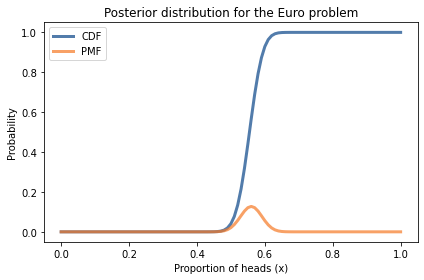

In [11]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result from `cumsum` is a Pandas Series, so we can use the bracket operator to select an element:

In [12]:
cumulative[0.61]

0.9638303193984253

The result is about 0.96, which means that the total probability of all quantities less than or equal to 0.61 is 96%.

To go the other way --- to look up a probability and get the corresponding quantile --- we can use interpolation:

In [13]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

The result is about 0.61, so that confirms that the 96th percentile of this distribution is 0.61.

`empiricaldist` provides a class called `Cdf` that represents a cumulative distribution function.
Given a `Pmf`, you can compute a `Cdf` like this:

In [14]:
cdf = pmf.make_cdf()

`make_cdf` uses `np.cumsum` to compute the cumulative sum of the probabilities.

You can use brackets to select an element from a `Cdf`:

In [15]:
cdf[0.61]

0.9638303193984253

But if you look up a quantity that's not in the distribution, you get a `KeyError`.


In [26]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a `Cdf` as a function, using parentheses.
If the argument does not appear in the `Cdf`, it interpolates between quantities.

In [27]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use `quantile` to look up a cumulative probability and get the corresponding quantity:


In [28]:
cdf.quantile(0.9638303)

array(0.61)

`Cdf` also provides `credible_interval`, which computes a credible interval that contains the given probability:


In [29]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the
same information about the distribution, and you can always convert
from one to the other.
Given a `Cdf`, you can get the equivalent `Pmf` like this:

In [30]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three.
For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character's strength would be the sum of 2, 3, and 4, which is 9.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

I'll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of `Pmf` objects and computes the distribution of their sum.

Here's a `Pmf` that represents a six-sided die and a sequence with three references to it.

In [31]:
from utils import make_die

die = make_die(6)
dice = [die] * 3

And here's the distribution of the sum of three dice.

In [32]:
from utils import add_dist_seq

pmf_3d6 = add_dist_seq(dice)

Here's what it looks like:

In [33]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

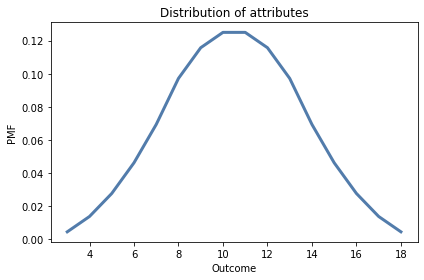

In [34]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.
I'll estimate the distribution by simulating 10,000 rolls.

First I'll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

In [35]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

To find the best three outcomes in each row, I'll sort along `axis=1`, which means across the columns.

In [36]:
a.sort(axis=1)

Finally, I'll select the last three columns and add them up.

In [37]:
t = a[:, 1:].sum(axis=1)

Now `t` is an array with a single column and 10,000 rows.
We can compute the PMF of the values in `t` like this:

In [38]:
pmf_4d6 = Pmf.from_seq(t)

The following figure shows the distribution of the sum of three dice, `pmf_3d6`, and the distribution of the best three out of four, `pmf_4d6`.

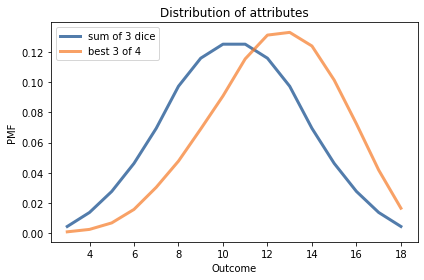

In [39]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_4d6.plot(label='best 3 of 4')

decorate_dice('Distribution of attributes')

As you might expect, choosing the best three out of four tends to yield higher values.

Next we'll find the distribution for the maximum of six attributes, each the sum of the best three of four dice.

## Maximum

To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

In [40]:
cdf_4d6 = pmf_4d6.make_cdf()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`.
Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution.
The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

In [41]:
cdf_4d6**6

3     1.771561e-18
4     3.010936e-15
5     1.586874e-12
6     3.622994e-10
7     3.502484e-08
8     1.340096e-06
9     2.775208e-05
10    3.447529e-04
11    3.015694e-03
12    1.782524e-02
13    7.127062e-02
14    2.047148e-01
15    4.306443e-01
16    6.960576e-01
17    9.038914e-01
18    1.000000e+00
dtype: float64

If all 6 values are less than or equal to `x`, that means that their maximum is less than or equal to `x`.
So the result is the CDF of their maximum.
We can convert it to a `Cdf` object, like this:

In [42]:
from empiricaldist import Cdf

cdf_max6 = Cdf(cdf_4d6**6)

And compute the equivalent `Pmf` like this:

In [43]:
pmf_max6 = cdf_max6.make_pmf()

The following figure shows the result.

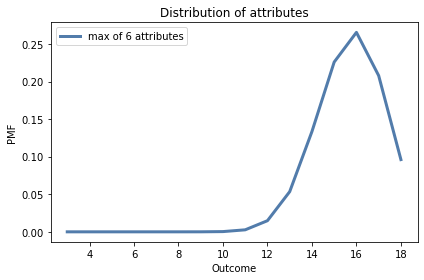

In [44]:
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

Most characters have at least one attribute greater than 12; almost 10\% of them have an 18.

The following figure shows the CDFs for the three distributions we have computed.

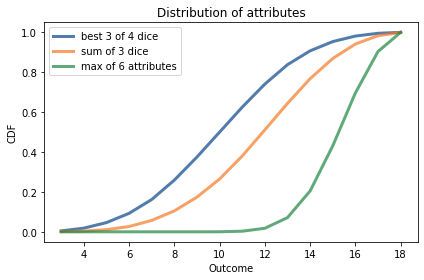

In [45]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='best 3 of 4 dice')

cdf_4d6 = pmf_4d6.make_cdf()
cdf_4d6.plot(label='sum of 3 dice')

cdf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Pmf` and `Cdf` provide `max_dist`, which does the same computation.
We can compute the `Pmf` of the maximum like this:

In [46]:
pmf_max_dist6 = pmf_4d6.max_dist(6)

And the `Cdf` of the maximum like this:


In [47]:
cdf_max_dist6 = cdf_4d6.max_dist(6)

And we can confirm that the differences are small.

In [48]:
np.allclose(pmf_max_dist6, pmf_max6)

True

In [49]:
np.allclose(cdf_max_dist6, cdf_max6)

True

In the next section we'll find the distribution of the minimum.
The process is similar, but a little more complicated.
See if you can figure it out before you go on.

## Minimum

In the previous section we computed the distribution of a character's best attribute.
Now let's compute the distribution of the worst.

To compute the distribution of the minimum, we'll use the **complementary CDF**, which we can compute like this:

In [50]:
prob_gt = 1 - cdf_4d6

As the variable name suggests, the complementary CDF is the probability that a value from the distribution is greater than `x`.
If we draw 6 values from the distribution, the probability that all 6 exceed `x` is:

In [51]:
prob_gt6 = prob_gt**6

If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF of the minimum.
And that means we can compute the CDF of the minimum like this:

In [52]:
prob_le6 = 1 - prob_gt6

The result is a Pandas `Series` that represents the CDF of the minimum of six attributes.  We can put those values in a `Cdf` object like this:

In [53]:
cdf_min6 = Cdf(prob_le6)

Here's what it looks like, along with the distribution of the maximum.

Text(27.0, 0.5, 'CDF')

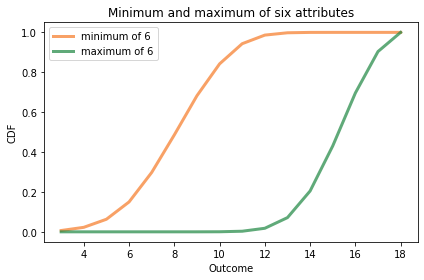

In [56]:
cdf_min6.plot(color='C1', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF')

From the `Cdf` we can make the corresponding `Pmf`:

In [57]:
pmf_min6 = cdf_min6.make_pmf()

`Pmf` and `Cdf` provide `min_dist`, which does the same computation.
We can compute the `Pmf` of the minimum like this:

In [58]:
pmf_min_dist6 = pmf_4d6.min_dist(6)

And the `Cdf` of the minimum like this:


In [59]:
cdf_min_dist6 = cdf_4d6.min_dist(6)

And we can confirm that the differences are small.

In [60]:
np.allclose(pmf_min_dist6, pmf_min6)

True

In [61]:
np.allclose(cdf_min_dist6, cdf_min6)

True

In the exercises at the end of this notebook, you'll use distributions of the minimum and maximum to do Bayesian inference.
But first we'll see what happens when we mix distributions.

## Mixture

In this section I'll show how we can compute a distribution which is a mixture of other distributions.
I'll explain what that means with some simple examples;
then, more usefully, we'll see how these mixtures are used to make predictions.

Here's another example inspired by *Dungeons & Dragons*:

* Suppose your character is armed with a dagger in one hand and a short sword in the other.

* During each round, attack a monster with one of your two weapons, chosen at random.

* The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

What is the distribution of damage you inflict in each round?

To answer this question, I'll make a `Pmf` to represent the 4-sided and 6-sided dice:

In [62]:
d4 = make_die(4)
d6 = make_die(6)

Now, let's compute the probability you inflict 1 point of damage.

* If you attacked with the dagger, it's 1/4.

* If you attacked with the short sword, it's 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is the average:

In [63]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

For the outcomes 2, 3, and 4, the probability is the same, but for 5 and 6 it's different, because those outcomes are impossible with the 4-sided die.

In [64]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

To compute the distribution of the mixture, we could loop through the possible outcomes and compute their probabilities.

But we can do the same computation using the `+` operator:

In [72]:
mix1 = (d4 + d6) / 2
mix1

,probs
1,0.208333
2,0.208333
3,0.208333
4,0.208333
5,0.083333
6,0.083333


Here's what the mixture of these distributions looks like.

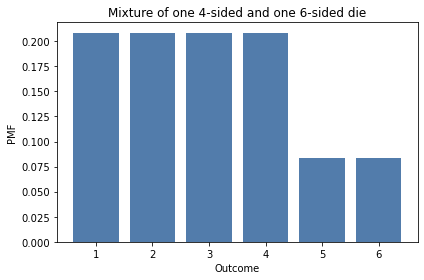

In [74]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

Now suppose you are fighting three monsters:

* One has a club, which causes one 4-sided die of damage.

* One has a mace, which causes one 6-sided die.

* And one has a quarterstaff, which also causes one 6-sided die. 

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random.

To find the distribution of the damage they inflict, we can compute a weighted average of the distributions, like this:

In [75]:
mix2 = (d4 + 2*d6) / 3

This distribution is a mixture of one 4-sided die and two 6-sided dice.
Here's what it looks like.

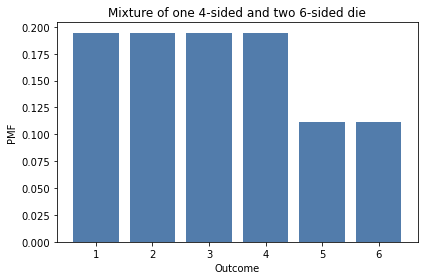

In [76]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In this section we used the `+` operator, which adds the probabilities in the distributions, not to be confused with `Pmf.add_dist`, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I'll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

In [77]:
total_damage = Pmf.add_dist(mix1, mix2)

And here's what it looks like.

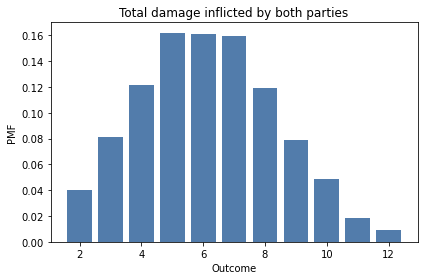

In [78]:
total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## More generally

In the previous section we computed mixtures in an *ad hoc* way.
Now we'll see a more general solution.

Continuing the previous example, suppose three more monsters join the combat, each of them with a battleaxe that causes one 8-sided die of damage.

Still, only one monster attacks per round, chosen at random, so the damage they inflict is a mixture of:

* one 4-sided die,
* two 6-sided dice, and
* three 8-sided dice.

I'll use a `Pmf` to represent a randomly chosen monster:

In [79]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


This distribution represents the number of sides on the die we'll roll and the probability of rolling each one.
For example, one of the six monsters has a dagger, so the probability is $1/6$ that we roll a 4-sided die.

Next I'll make a sequence of `Pmf` objects to represent the dice:

In [80]:
dice = [make_die(sides) for sides in hypos]

To compute the distribution of the mixture, I'll compute the weighted average of the dice, using the probabilities in `pmf_dice` as the weights.

To express this computation concisely, it is convenient to put the distributions into a Pandas `DataFrame`:

In [81]:
import pandas as pd

pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a DataFrame with one row for each distribution and one column for each possible outcome.
Not all rows are the same length, so Pandas fills the extra spaces with the special value `NaN`, which stands for ``not a number''.
We can use `fillna` to replace the `NaN` values with 0.

In [82]:
pd.DataFrame(dice).fillna(0)

,1,2,3,4,5,6,7,8
0,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000,0.000
1,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000,0.000
2,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The next step is to multiply each row by the probabilities in `pmf_dice`, which turns out to be easier if we transpose the matrix so the distributions run down the columns rather than across the rows:

In [83]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,0,1,2
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Now we can multiply by the probabilities in `pmf_dice`:


In [84]:
df *= pmf_dice.ps
df

,0,1,2
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:

In [85]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The argument `axis=1` means we want to sum across the rows.
The result is a Pandas Series.

Putting it all together, here's a function that makes a weighted mixture of distributions.

In [86]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions.
    
    pmf: mapping from each hypothesis to its probability
         (or it can be a sequence of probabilities)
    pmf_seq: sequence of Pmfs, each representing 
             a conditional distribution for one hypothesis
             
    returns: Pmf representing the mixture
    """
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

The first parameter is a `Pmf` that maps from each hypothesis to a probability.
The second parameter is a sequence of `Pmf` objects, one for each hypothesis.
We can call it like this:

In [87]:
mix = make_mixture(pmf_dice, dice)

And here's what it looks like.

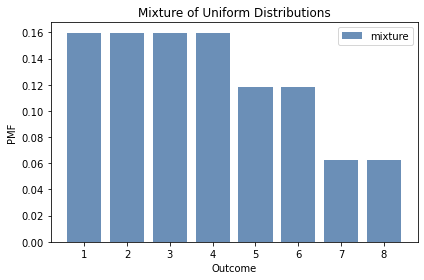

In [88]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Mixture of Uniform Distributions')

This section I used Pandas so that `make_mixture` is concise, efficient, and hopefully not too hard to understand.
In the exercises at the end of the chapter, you'll have a chance to practice with mixtures, and we will use `make_mixture` again in the next chapter.

## Summary 

This chapter introduces the `Cdf` object, which represents the cumulative distribution function (CDF).

A `Pmf` and the corresponding `Cdf` are equivalent in the sense that they contain the same information, so you can convert from one to the other.  
The primary difference between them is performance: some operations are faster and easier with a `Pmf`; others are faster with a `Cdf`.

In this chapter we used `Cdf` objects to compute distributions of maximums and minimums; these distributions are useful for inference if we are given a maximum or minimum as data.
You will see some examples in the exercises, and in future chapters.

We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

But first you might want to work on these exercises.

## Exercises

**Exercise:** When you generate a D&D character, instead of rolling dice, you can use the "standard array" of attributes, which is 15, 14, 13, 12, 10, and 8.

Do you think you are better off using the standard array or (literally) rolling the dice?

Compare the distribution of the values in the standard array to the distribution we computed for the best three out of four:

* Which distribution has higher mean?  Use the `mean` method.

* Which distribution has higher standard deviation?  Use the `std` method.

* The lowest value in the standard array is 8.  For each attribute, what is the probability of getting a value less than 8?  If you roll the dice six times, what's the probability that at least one of your attributes is less than 8?

* The highest value in the standard array is 15.  For each attribute, what is the probability of getting a value greater than 15?  If you roll the dice six times, what's the probability that at least one of your attributes is greater than 15?

To get you started, here's a `Cdf` that represents the distribution of attributes in the standard array:

In [89]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

We can compare it to the distribution of attributes you get by rolling four dice at adding up the best three.

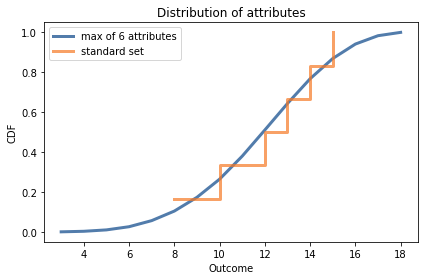

In [90]:
cdf_4d6.plot(label='max of 6 attributes')
cdf_standard.step(label='standard set')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

I plotted `cdf_standard` as a step function to show more clearly that it contains only a few quantities.

In [91]:
# Solution

# Here are the means
cdf_4d6.mean(), cdf_standard.mean()

(12.260100000000003, 12.0)

In [92]:
# Solution

# And the standard deviations
cdf_4d6.std(), cdf_standard.std()

(2.8431053427546438, 2.3804761428476167)

In [93]:
# Solution

# Here's the probability that a single attribute is less than 8
cdf_4d6.lt_dist(8)

0.0572

In [94]:
# Solution

# And the probability that a single attribute is greater than 15
cdf_4d6.gt_dist(15)

0.131

In [95]:
# Solution

# Here are two ways to compute the probability that at
# least one attribute is less than 8
cdf_min6.lt_dist(8), 1 - (1-cdf_4d6.lt_dist(8))**6

(0.29770844981474853, 0.29770844981474853)

In [96]:
# Solution

# And two ways to compute the probability that at least
# one attribute is greater than 15
cdf_max6.gt_dist(15), 1 - (1-cdf_4d6.gt_dist(15))**6

(0.5693557442097624, 0.5693557442097618)

**Exercise:** Suppose you are fighting three monsters:

* One is armed with a short sword that causes one 6-sided die of damage,

* One is armed with a battleaxe that causes one 8-sided die of damage, and

* One is armed with a bastard sword that causes one 10-sided die of damage.

One of the monsters, chosen at random, attacks you and does 1 point of damage.

Which monster do you think it was?  Compute the posterior probability that each monster was the attacker.

If the same monster attacks you again, what is the probability that you suffer 6 points of damage?

Hint: Compute a posterior distribution as we have done before and pass it as one of the arguments to `make_mixture`.

In [97]:
# Solution

# Here's what we believe about the dice after seeing the data

hypos = [6, 8, 10]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.425532
8,0.319149
10,0.255319


In [98]:
# Solution

# Here's a sequence that represents the three dice

d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

dice = d6, d8, d10

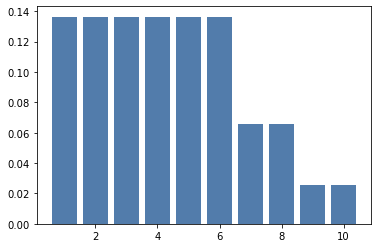

In [99]:
# Solution

# And here's a mixture of the three dice, weighting
# each one with the probability from the posterior distribution

mix3 = make_mixture(posterior, dice)
mix3.bar()

In [100]:
# Solution

# From the mixture, we can pull out the probability of
# rolling a 6.

mix3[6]

0.13634751773049647

**Exercise:**  Suppose I have two boxes of dice:

* One contains a 4-sided die and a 6-sided die.

* The other contains a 6-sided die and an 8-sided die.

I choose a box at random, choose a die, and roll it 3 times.  If I get 2, 4, and 6, which box do you think I chose?

In [101]:
# Solution

# I'll make some objects to represent the dice.

d4 = make_die(4)
d6 = make_die(6)
d8 = make_die(8)

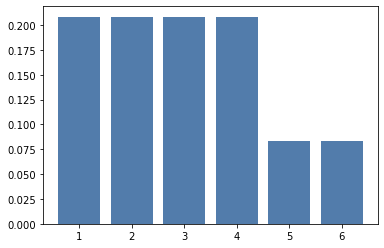

In [102]:
# Solution

# Here's a mixture that represents the result of
# rolling a die from the first box.

pmf1 = Pmf(1/2, [4, 6])
mix1 = make_mixture(pmf1, [d4, d6])
mix1.bar(alpha=0.7)

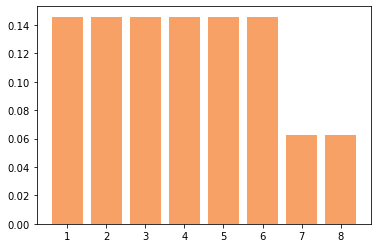

In [103]:
# Solution

# Here's the distribution of outcomes from the second box.

pmf2 = Pmf(1/2, [6, 8])
mix2 = make_mixture(pmf2, [d6, d8])
mix2.bar(color='C1', alpha=0.7)

In [104]:
# Solution

# Here are the likelihoods of getting the data from the first box

data = [2, 4, 6]
mix1(data)

array([0.20833333, 0.20833333, 0.08333333])

In [105]:
# Solution

# And here are the likelihood from the second box

mix2(data)

array([0.14583333, 0.14583333, 0.14583333])

In [106]:
# Solution

# The overall likelihood of the data is the product
# of the likelihoods we just computed

likelihood = [mix1(data).prod(), mix2(data).prod()]
likelihood

[0.0036168981481481473, 0.003101490162037036]

In [107]:
# Solution

# Finally, we can do the update in the usual way

prior = Pmf(1/2, ['Box 1', 'Box 2'])
posterior = (prior * likelihood)
posterior.normalize()
posterior

,probs
Box 1,0.538358
Box 2,0.461642


**Exercise:** Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900. The following anecdote about him is probably fiction, but it makes an interesting probability problem.

Supposedly Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued the practice of weighing his bread every day. At the end of the year, he found that the average weight was 1000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

To see whether this anecdote is plausible, let's suppose that when the baker sees Poincaré coming, he hefts `n` loaves of bread and gives Poincaré the heaviest one.  How many loaves would the baker have to heft to make the average of the maximum 1000 g?

To get you started, I'll generate a year's worth of data from a normal distribution with the given parameters.

In [108]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [109]:
# Solution

# Here's the mean of the maximum of `n` loaves,
# for a range of values of `n`

cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 978.4666876067706
3 992.7589004318227
4 1002.0372868686195
5 1008.8226939493089


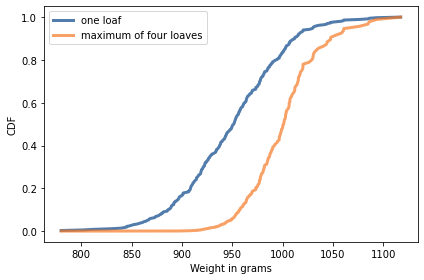

In [110]:
# Solution

# It looks like hefting 4 loaves is enough to get the mean over 1000,
# so the story is not entirely implausible.

# Here's what the distribution of the maximum looks like, compared
# to the actual distribution of weights.

cdf.plot(label='one loaf')
cdf.max_dist(4).plot(label='maximum of four loaves')

decorate(xlabel='Weight in grams',
         ylabel='CDF')

Note: The following exercise uses a Poisson distribution, which we will see in Section xx.
If you are not familiar with the Poisson distribution, you might want to skip this exercise and come back to it later.

**Exercise:**  Two doctors fresh out of medical school are arguing about whose hospital delivers more babies.  The first doctor says, "I've been at Hospital A for one week, and already we've had a day when we delivered 19 babies."

The second doctor says, "I've been at Hospital B for two weeks, and already there's been a 20-baby day."

Which hospital do you think delivers more babies on average?  You can assume that the number of babies born in a day is well modeled by a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with parameter $\lambda$, which is the Greek letter pronounced "lambda".

The following function computes the PMF of a Poisson distribution with parameter `lam` over a range of integers, `qs`:

In [111]:
from scipy.stats import poisson

def make_poisson_pmf(lam, qs):
    """Make a PMF of a Poisson distribution.
    
    lam: event rate
    qs: sequence of values for `k`
    
    returns: Pmf
    """
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

For example, if the actual value of $\lambda$ is 8, we can compute the distribution of babies born in a single day like this:

In [112]:
lam = 8
qs = np.arange(24)
pmf = make_poisson_pmf(lam, qs)

And here's what it looks like.

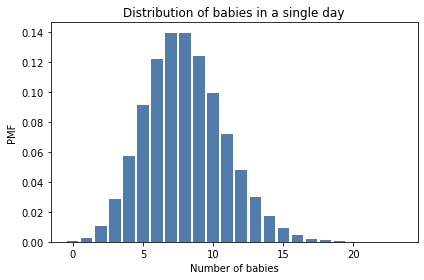

In [113]:
pmf.bar(alpha=0.7)
decorate(xlabel='Number of babies', 
         ylabel='PMF',
         title='Distribution of babies in a single day')

The mean of this distribution is the parameter, $\lambda$.

In [114]:
pmf.mean()

7.999938721091352

And here's what the distributions look like for the maximum number of babies after one week or two weeks.

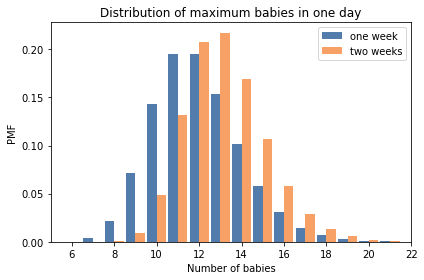

In [115]:
pmf_max1 = pmf.max_dist(7)
pmf_max1.bar(label='one week', align='edge', width=-0.45)

pmf_max2 = pmf.max_dist(2 * 7)
pmf_max2.bar(label='two weeks', align='edge', width=0.45)

decorate(xlabel='Number of babies',
         xlim=[5, 22],
         ylabel='PMF',
         title='Distribution of maximum babies in one day')

Now you finish it off from there.

In [116]:
# Solution

# Here's a prior distribution for the values of lamdba

hypos = np.linspace(0, 25, 101)
prior = Pmf(1, hypos)

In [117]:
# Solution

# Here's the likelihood of the data for each hypothetical
# value of lambda, for the doctor who reported the maximum
# number of babies in one week

days = 1 * 7      # one week
data = 19         # maximum of 19 babies

likelihood1 = [make_poisson_pmf(hypo, qs).max_dist(days)(data)
               for hypo in hypos]

In [118]:
# Solution

# And here's the first posterior distribution

posterior1 = prior * likelihood1
posterior1.normalize()

4.201483589848796

In [119]:
# Solution

# Here's the likelihood for the doctor who reported the
# maximum number of babies in two weeks.

days = 2 * 7
data = 20

likelihood2 = [make_poisson_pmf(hypo, qs).max_dist(days)(data)
               for hypo in hypos]

In [120]:
# Solution

# And here's the second posterior

posterior2 = prior * likelihood2
posterior2.normalize()

4.259983296308155

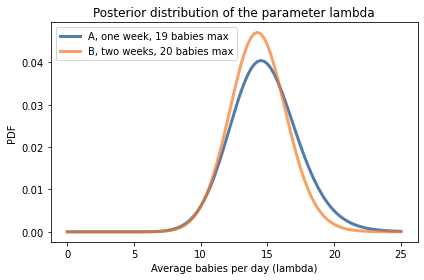

In [121]:
# Solution

# And here's what the two posterior distributions look like

posterior1.plot(label='A, one week, 19 babies max')
posterior2.plot(label='B, two weeks, 20 babies max')

decorate(xlabel='Average babies per day (lambda)', 
         ylabel='PDF',
         title='Posterior distribution of the parameter lambda')

In [122]:
# Solution

# The posterior mean is a little higher for hospital a,
# based on one week of data and a slightly lower maximum

posterior1.mean(), posterior2.mean()

(14.794330239819137, 14.327038448986379)